In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing necessary libraries

# File system and paths
from pathlib import Path
import os

# Data formats and serialization
import json

# Visualization
import matplotlib.pyplot as plt

# Image processing
import cv2
import skimage.io as io

# Data manipulation and numerical operations
import pandas as pd
import numpy as np
from collections import defaultdict

# Random operations
import random

# COCO dataset tools
from pycocotools.coco import COCO

# PyTorch and Torchvision
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader



In [ ]:
# Dataset Structure Overview

drive.mount('/content/drive')
dataset_path = Path("/content/drive/MyDrive/RM_Segmentation_Assignment_dataset")
train_path = Path("/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300")
val_path = Path("/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300")
test_path = Path("/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/test-30")

for split in ['train-300', 'validation-300', 'test-30']:
    split_path = dataset_path / split
    print(f"\nContents of {split}:")
    for file in sorted(split_path.iterdir()):
        print("  -", file.name)

train_path = dataset_path / "train-300"
val_path = dataset_path / "validation-300"
test_path = dataset_path / "test-30"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Contents of train-300:
  - data
  - labels.json

Contents of validation-300:
  - data
  - labels.json

Contents of test-30:
  - 000000001371.jpg
  - 000000001380.jpg
  - 000000001385.jpg
  - 000000001410.jpg
  - 000000001411.jpg
  - 000000001418.jpg
  - 000000001439.jpg
  - 000000001444.jpg
  - 000000001459.jpg
  - 000000001482.jpg
  - 000000001492.jpg
  - 000000001494.jpg
  - 000000001550.jpg
  - 000000001551.jpg
  - 000000001583.jpg
  - 000000001594.jpg
  - 000000001600.jpg
  - 000000001643.jpg
  - 000000001650.jpg
  - 000000001653.jpg
  - 000000001654.jpg
  - 000000001657.jpg
  - 000000001671.jpg
  - 000000001685.jpg
  - 000000001702.jpg
  - 000000001717.jpg
  - 000000001730.jpg
  - 000000001750.jpg
  - 000000001751.jpg
  - 000000001773.jpg


In [ ]:
# Image Inspection and Dimensions
def inspect_images(folder_path, n_samples=3):
    image_paths = list(Path(folder_path).glob("*.jpg")) + list(Path(folder_path).glob("*.png"))
    print(f"\nTotal images in {folder_path.name}: {len(image_paths)}")
    sampled_paths = random.sample(image_paths, min(n_samples, len(image_paths)))
    for img_path in sampled_paths:
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w, c = img.shape
            print(f" - {img_path.name}: {w}x{h}, Channels: {c}")
        else:
            print(f" - Failed to load {img_path.name}")

inspect_images(train_path / "data")
inspect_images(val_path / "data")


Total images in data: 300
 - 000000003793.jpg: 640x428, Channels: 3
 - 000000002998.jpg: 640x463, Channels: 3
 - 000000002640.jpg: 640x480, Channels: 3

Total images in data: 300
 - 000000107087.jpg: 640x427, Channels: 3
 - 000000142585.jpg: 375x500, Channels: 3
 - 000000255917.jpg: 640x427, Channels: 3


Top-level keys: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Total images in annotation: 300
Total annotations: 3870
Total categories: 63

Category List:
 - 0: airplane
 - 1: backpack
 - 2: banana
 - 3: baseball bat
 - 4: baseball glove
 - 5: bear
 - 6: bench
 - 7: bicycle
 - 8: bird
 - 9: boat
 - 10: book
 - 11: bottle
 - 12: bowl
 - 13: broccoli
 - 14: bus
 - 15: cake
 - 16: car
 - 17: carrot
 - 18: cat
 - 19: cell phone
 - 20: chair
 - 21: clock
 - 22: cow
 - 23: cup
 - 24: dining table
 - 25: dog
 - 26: donut
 - 27: elephant
 - 28: fire hydrant
 - 29: fork
 - 30: frisbee
 - 31: giraffe
 - 32: handbag
 - 33: horse
 - 34: hot dog
 - 35: kite
 - 36: knife
 - 37: laptop
 - 38: motorcycle
 - 39: oven
 - 40: parking meter
 - 41: person
 - 42: pizza
 - 43: potted plant
 - 44: refrigerator
 - 45: remote
 - 46: sandwich
 - 47: scissors
 - 48: skateboard
 - 49: skis
 - 50: spoon
 - 51: sports ball
 - 52: stop sign
 - 53: suitcase
 - 54: surfboard
 - 55: tennis racke

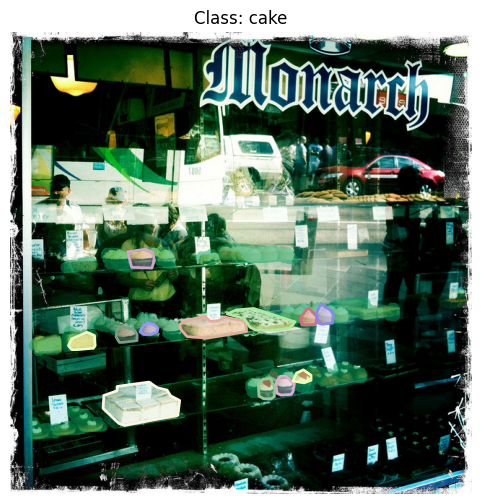

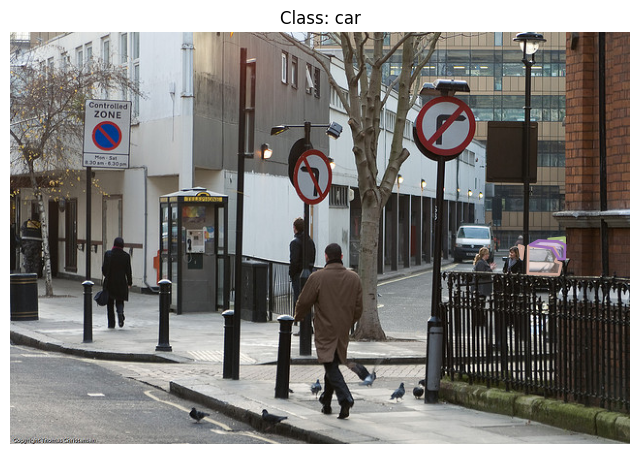

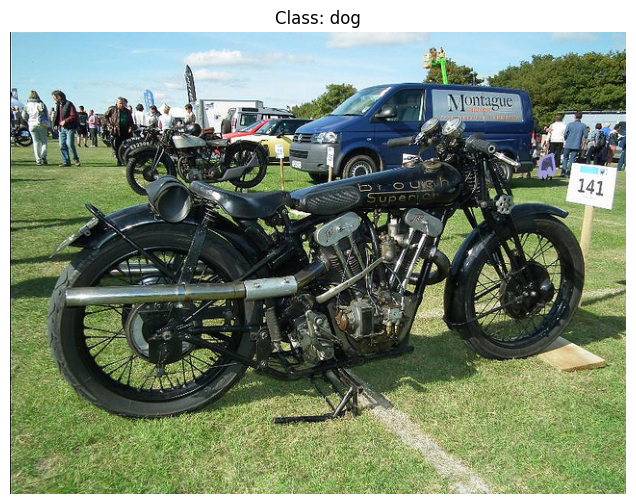

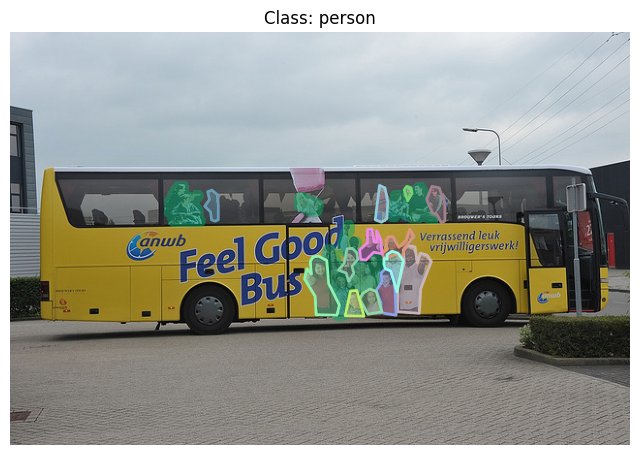

In [ ]:
# COCO Annotations and Target Class Extraction
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io as io

with open(train_path / "labels.json", "r") as f:
    train_labels = json.load(f)

print("Top-level keys:", train_labels.keys())
print("Total images in annotation:", len(train_labels['images']))
print("Total annotations:", len(train_labels['annotations']))
print("Total categories:", len(train_labels['categories']))

print("\nCategory List:")
for cat in train_labels['categories']:
    print(f" - {cat['id']}: {cat['name']}")

coco = COCO(train_path / "labels.json")
target_class_ids = [15, 16, 25, 41]
class_names = {15: "cake", 16: "car", 25: "dog", 41: "person"}

def show_random_image_for_class(coco, cat_id):
    img_ids = coco.getImgIds(catIds=cat_id)
    if not img_ids:
        return
    img_id = random.choice(img_ids)
    img_data = coco.loadImgs(img_id)[0]
    image = io.imread(os.path.join(train_path / "data", img_data['file_name']))
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
    anns = coco.loadAnns(ann_ids)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    coco.showAnns(anns)
    plt.axis('off')
    plt.title(f"Class: {class_names[cat_id]}")
    plt.show()

for cat_id in target_class_ids:
    show_random_image_for_class(coco, cat_id)

In [ ]:
# Data loading and filtering

def filter_and_load_data(coco, image_dir, target_class_ids):
    filtered = {"images": [], "masks": [], "labels": []}
    for img_id in coco.getImgIds():
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id, catIds=target_class_ids))
        if not anns:
            continue
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_info["file_name"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        masks = []
        labels = []
        for ann in anns:
            mask = coco.annToMask(ann)
            if mask.sum() < 100:  # Skip very small masks
                continue
            masks.append(mask)
            labels.append(ann["category_id"])
        if masks:
            filtered["images"].append(image)
            filtered["masks"].append(masks)
            filtered["labels"].append(labels)
    return filtered

# Defining paths and loading annotations:
filtered_data = filter_and_load_data(coco, os.path.join(train_path, "data"), target_class_ids)


In [ ]:
#  Mask Processing and Filtering
from pycocotools import mask as coco_mask
import numpy as np

filtered_data = {'images': [], 'masks': [], 'labels': [], 'image_info': []}
target_img_ids = sorted(set().union(*(coco.getImgIds(catIds=[i]) for i in target_class_ids)))

def process_mask(segmentation, img_height, img_width):
    if isinstance(segmentation, list):
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        for seg in segmentation:
            if len(seg) >= 6:
                poly = np.array(seg).reshape((-1, 2))
                cv2.fillPoly(mask, [poly.astype(np.int32)], 1)
        return mask
    else:
        try:
            return coco_mask.decode(segmentation)
        except:
            return None

for img_id in target_img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = train_path / "data" / img_info['file_name']
    if not img_path.exists(): continue
    img = cv2.imread(str(img_path))
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=target_class_ids)
    anns = coco.loadAnns(ann_ids)
    masks, labels = [], []
    for ann in anns:
        mask = process_mask(ann['segmentation'], h, w)
        if mask is not None and mask.sum() > 0:
            masks.append(mask)
            labels.append(ann['category_id'])
    if masks:
        filtered_data['images'].append(img)
        filtered_data['masks'].append(masks)
        filtered_data['labels'].append(labels)
        filtered_data['image_info'].append(img_info)

print("Total unique images with target classes:", len(target_img_ids))
print("Processed training data:")
print("Images with valid masks:", len(filtered_data['images']))


Total unique images with target classes: 300
Processed training data:
Images with valid masks: 300


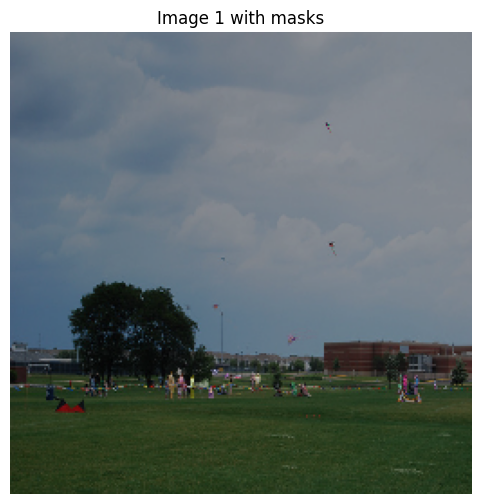

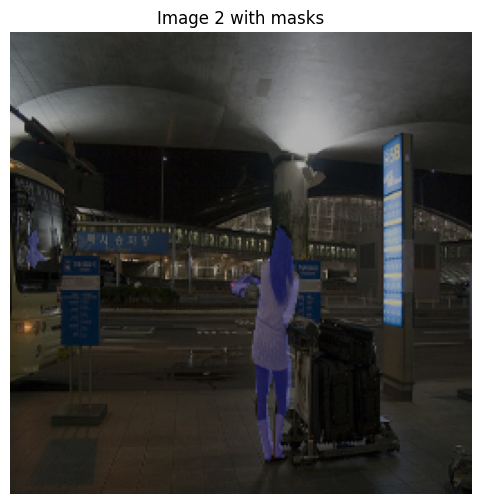

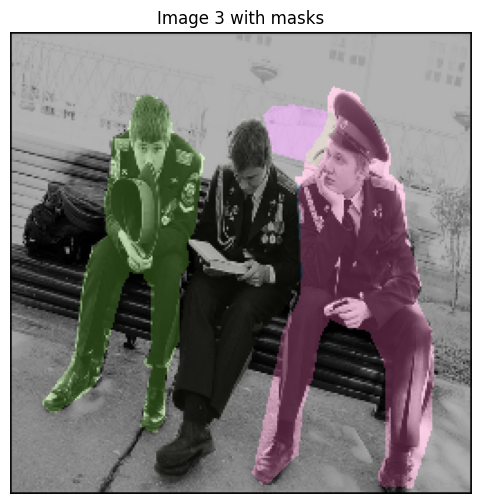

In [ ]:
# Visualizing Sample Masks
resize_shape = (256, 256)
for i in range(3):
    image = filtered_data['images'][i]
    masks = filtered_data['masks'][i]
    labels = filtered_data['labels'][i]
    image_resized = cv2.resize(image, resize_shape)
    combined_mask = np.zeros((resize_shape[1], resize_shape[0], 3), dtype=np.uint8)
    for mask, label in zip(masks, labels):
        mask_resized = cv2.resize(mask.astype(np.uint8), resize_shape, interpolation=cv2.INTER_NEAREST)
        color = np.random.randint(0, 255, size=3)
        for c in range(3):
            combined_mask[:, :, c] += (mask_resized * color[c]).astype(np.uint8)
    overlay = cv2.addWeighted(image_resized, 0.7, combined_mask, 0.3, 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"Image {i+1} with masks")
    plt.axis('off')
    plt.show()

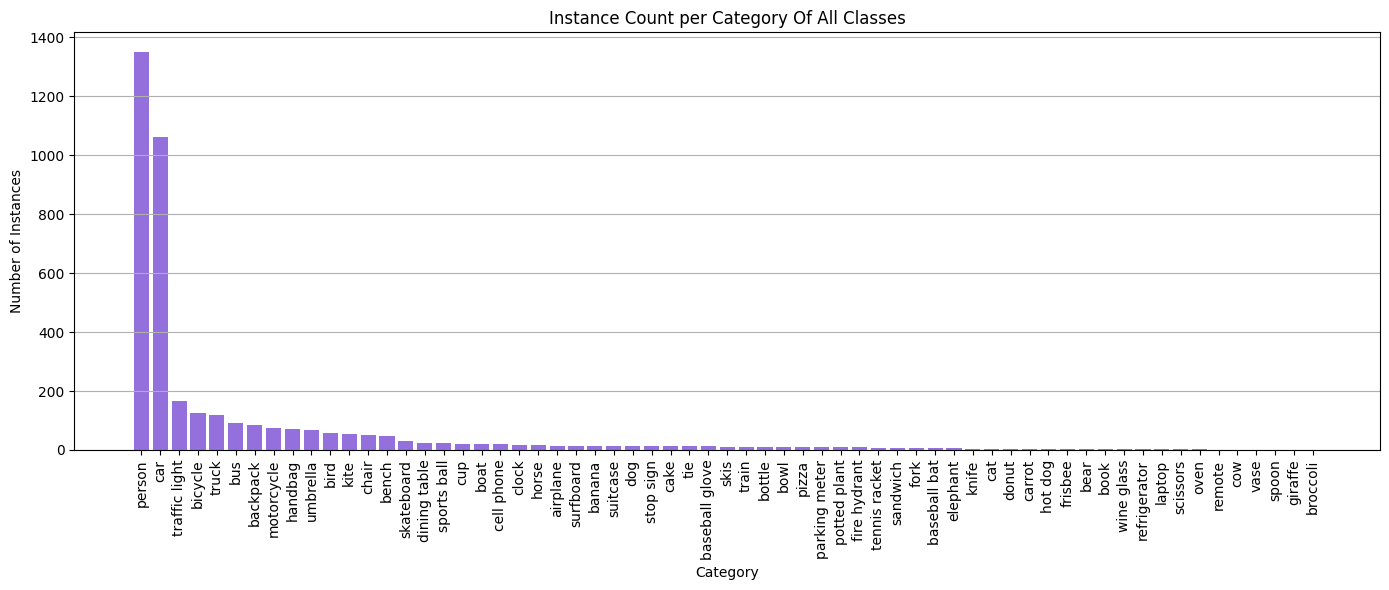

In [ ]:
# Distribution across all classes
all_cat_counts = defaultdict(int)
for ann in train_labels['annotations']:
    cat_id = ann['category_id']
    all_cat_counts[cat_id] += 1
id_to_name = {cat['id']: cat['name'] for cat in train_labels['categories']}
sorted_items = sorted(all_cat_counts.items(), key=lambda x: x[1], reverse=True)
sorted_labels = [id_to_name[i[0]] for i in sorted_items]
sorted_counts = [i[1] for i in sorted_items]

plt.figure(figsize=(14, 6))
plt.bar(sorted_labels, sorted_counts, color='mediumpurple')
plt.xticks(rotation=90)
plt.title("Instance Count per Category Of All Classes")
plt.xlabel("Category")
plt.ylabel("Number of Instances")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

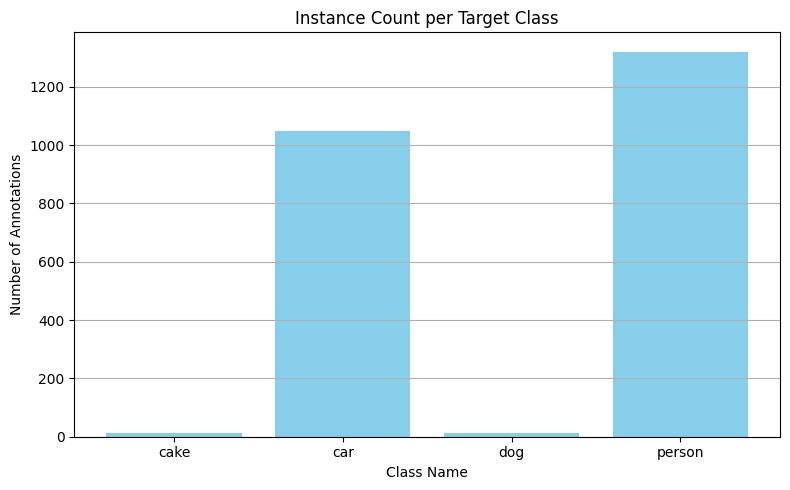

In [ ]:
# Target Class-wise Annotation Distribution
from collections import defaultdict

class_count = defaultdict(int)
for labels in filtered_data['labels']:
    for label in labels:
        class_count[label] += 1

plt.figure(figsize=(8, 5))
plt.bar([class_names[cid] for cid in target_class_ids], [class_count[cid] for cid in target_class_ids], color='skyblue')
plt.title("Instance Count per Target Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Annotations")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

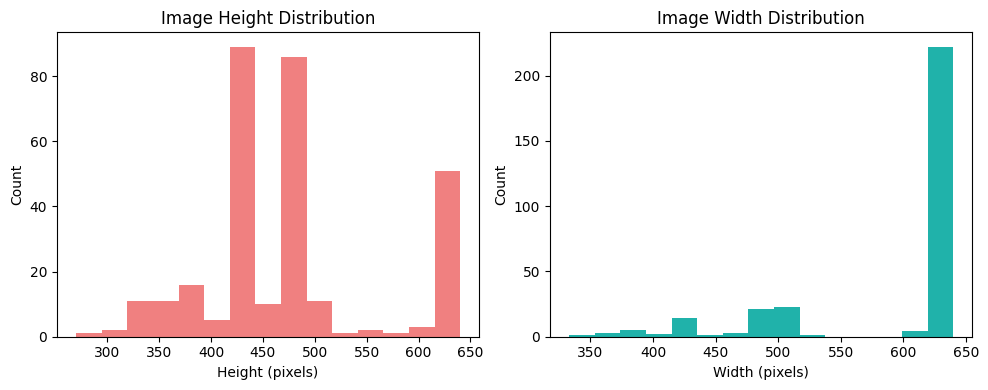

In [ ]:
# Image Dimension and Aspect Ratio Analysis
img_shapes = [img.shape[:2] for img in filtered_data['images']]
heights = [h for h, w in img_shapes]
widths = [w for h, w in img_shapes]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(heights, bins=15, color='lightcoral')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(widths, bins=15, color='lightseagreen')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
# Dataset Split Summary Table
val_ann_path = val_path / "labels.json"
with open(val_ann_path, "r") as f:
    val_labels = json.load(f)

train_images = len(filtered_data['images'])
train_instances = sum(len(labels) for labels in filtered_data['labels'])
val_instances = len(val_labels['annotations'])
val_images = len(val_labels['images'])
test_images = len(list(test_path.glob("*.jpg")))

print(" Dataset Split Summary")
print("="*35)
print(f"{'Split':<12}{'Images':<10}{'Total_Instances'}")
print(f"{'Train':<12}{train_images:<10}{train_instances}")
print(f"{'Validation':<12}{val_images:<10}{val_instances}")
print(f"{'Test':<12}{test_images:<10}N/A (no labels)")


 Dataset Split Summary
Split       Images    Total_Instances
Train       300       2395
Validation  300       3774
Test        30        N/A (no labels)


In [ ]:
# Mask Area Analysis
mask_area_stats = defaultdict(list)
for masks, labels in zip(filtered_data['masks'], filtered_data['labels']):
    for mask, label in zip(masks, labels):
        if label in target_class_ids:
            area = np.sum(mask)
            mask_area_stats[label].append(area)

mask_data = []
for label_id in target_class_ids:
    areas = mask_area_stats[label_id]
    if areas:
        mask_data.append({
            'Class': class_names[label_id],
            'Train_Avg_Area': round(np.mean(areas), 2),
            'Train_Std_Area': round(np.std(areas), 2),
            'Train_Min_Area': int(np.min(areas)),
            'Train_Max_Area': int(np.max(areas))
        })


print(" Mask Size Analysis Train only on Target Class:")
pd.DataFrame(mask_data)

 Mask Size Analysis Train only on Target Class:


Class  Train_Avg_Area  Train_Std_Area  Train_Min_Area  Train_Max_Area
0    cake         1098.25         1193.44             312            4652
1     car         3843.15        13481.65               7          243491
2     dog         8529.50        13800.77              97           49398
3  person         5088.43        13364.88               4          153050

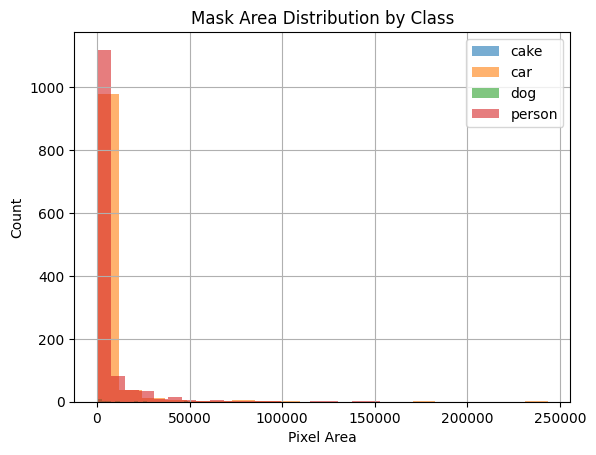

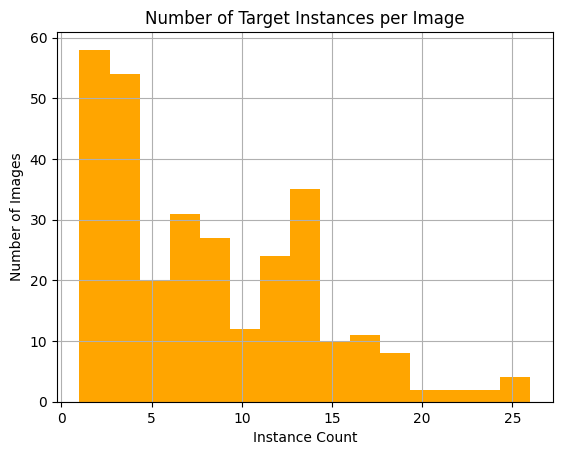

In [ ]:
# Plot for  mask area distribution
for class_id in [15, 16, 25, 41]:
    plt.hist(mask_area_stats[class_id], bins=20, alpha=0.6, label=id_to_name[class_id])
plt.legend()
plt.title("Mask Area Distribution by Class")
plt.xlabel("Pixel Area")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# plot to Count instance
instance_counts = [len(l) for l in filtered_data['labels']]
plt.hist(instance_counts, bins=15, color='orange')
plt.title("Number of Target Instances per Image")
plt.xlabel("Instance Count")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


In [ ]:
#!pip install --upgrade torch torchvision --quiet


In [ ]:
#!pip install torch==2.1.1 torchvision==0.16.1 --index-url https://download.pytorch.org/whl/cu121 --force-reinstall


In [ ]:
#!pip install torch==2.1.2 torchvision==0.16.1 --index-url https://download.pytorch.org/whl/cu121 --force-reinstall


# U-Net Architecture

In [ ]:
# Building U-Net Architecture

import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):  # 4 classes: cake, car, dog, person
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.center = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        center = self.center(self.pool4(e4))

        d4 = self.up4(center)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.decoder4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)

        out = self.final(d1)
        return out


In [ ]:
#Initialize Model, Loss, Optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import os
import cv2

class SegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_classes=None):
        self.data_dir = data_dir
        self.image_dir = data_dir / "data"
        self.annotation_file = data_dir / "labels.json"
        self.coco = COCO(self.annotation_file)
        self.transform = transform
        self.target_classes = target_classes

        # Filter images containing the target classes
        if self.target_classes:
            valid_image_ids = []
            for img_id in self.coco.getImgIds():
                ann_ids = self.coco.getAnnIds(imgIds=img_id)
                anns = self.coco.loadAnns(ann_ids)
                labels = [ann['category_id'] for ann in anns]
                if any(label in self.target_classes for label in labels):
                    valid_image_ids.append(img_id)
            self.image_ids = valid_image_ids
        else:
            self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = self.image_dir / image_info["file_name"]

        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))
        image = np.array(image)

        ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=self.target_classes)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((256, 256), dtype=np.uint8)
        for ann in anns:
            mask_instance = self.coco.annToMask(ann)
            mask_instance = cv2.resize(mask_instance, (256, 256), interpolation=cv2.INTER_NEAREST)
            category_id = ann['category_id']
            if category_id in self.target_classes:
                class_index = self.target_classes.index(category_id)
                mask[mask_instance == 1] = class_index

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [ ]:
# Defining the Loss Function and Optimizer

import torch.optim as optim
learning_rate = 1e-4

unet = UNet(in_channels=3, out_channels=4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)

In [ ]:
# Preparing  DataLoaders

from torch.utils.data import DataLoader

train_dataset = SegmentationDataset(train_path, target_classes=[15, 16, 25, 41])
val_dataset = SegmentationDataset(val_path, target_classes=[15, 16, 25, 41])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)



loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import os
import cv2

class SegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_classes=None):
        self.data_dir = data_dir
        self.image_dir = data_dir / "data"
        self.annotation_file = data_dir / "labels.json"
        self.coco = COCO(self.annotation_file)
        self.transform = transform
        self.target_classes = target_classes

        self.cat_id_to_index = {cat_id: i for i, cat_id in enumerate(self.target_classes)}

        # Filtering images containing the target classes
        if self.target_classes:
            valid_image_ids = []
            for img_id in self.coco.getImgIds():
                ann_ids = self.coco.getAnnIds(imgIds=img_id)
                anns = self.coco.loadAnns(ann_ids)
                labels = [ann['category_id'] for ann in anns]

                if any(label in self.target_classes for label in labels):
                    valid_image_ids.append(img_id)
            self.image_ids = valid_image_ids
        else:
            self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = self.image_dir / image_info["file_name"]

        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))
        image = np.array(image)

        ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=self.target_classes)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.full((256, 256), 255, dtype=np.uint8)
        anns = sorted(anns, key=lambda x: x['area'], reverse=True)

        for ann in anns:
            category_id = ann['category_id']
            if category_id in self.target_classes:

                mask_instance = self.coco.annToMask(ann)
                mask_instance_resized = cv2.resize(mask_instance, (256, 256), interpolation=cv2.INTER_NEAREST)
                class_index = self.cat_id_to_index[category_id]
                mask[mask_instance_resized == 1] = class_index

        # Converting image and mask to tensors
        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [ ]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))


Number of training images: 300
Number of validation images: 300


# Train the U-Net Model

In [ ]:
#Training the U-NET Model
# Seting the Training Parameters and Device

import torch.nn as nn
import torch.optim as optim



In [ ]:
# Defining the  Loss Function and Optimizer

unet = UNet(in_channels=3, out_channels=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)


# Training and Validation Loss & Validation IoU Score

Epoch [1/5] - Train Loss: 0.4484, IoU: 0.2276 - Val Loss: 0.3686, IoU: 0.2726 - Time: 37.00s
Epoch [2/5] - Train Loss: 0.4376, IoU: 0.2648 - Val Loss: 0.3599, IoU: 0.2684 - Time: 36.74s
Epoch [3/5] - Train Loss: 0.4298, IoU: 0.2369 - Val Loss: 0.3627, IoU: 0.2780 - Time: 45.71s
Epoch [4/5] - Train Loss: 0.4237, IoU: 0.2490 - Val Loss: 0.3362, IoU: 0.2748 - Time: 39.91s
Epoch [5/5] - Train Loss: 0.4207, IoU: 0.2425 - Val Loss: 0.3357, IoU: 0.2704 - Time: 35.80s


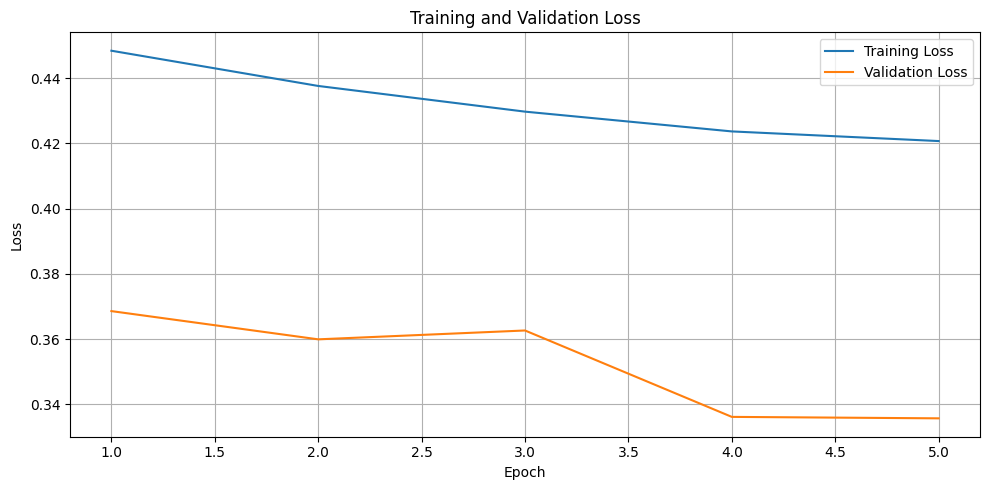

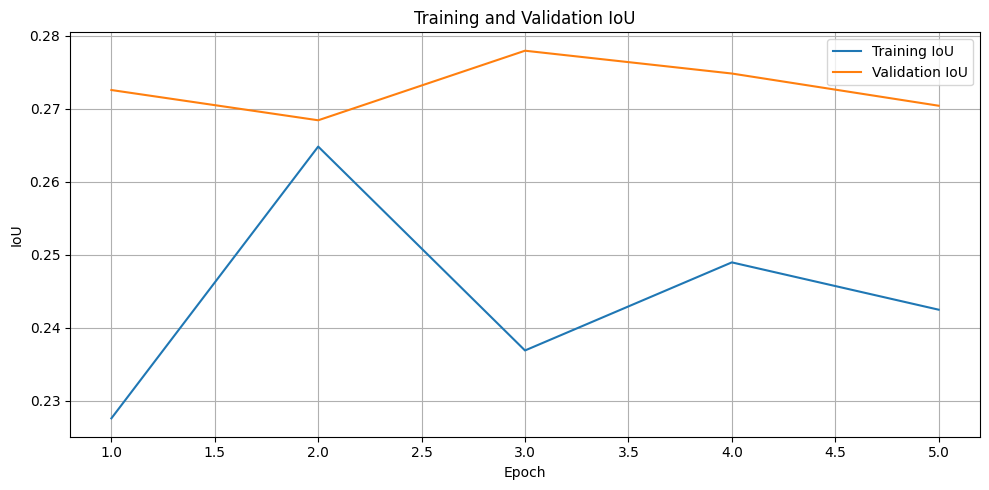

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
import numpy as np

def calculate_iou(preds, targets, threshold=0.5):

    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = ((preds + targets) >= 1).float().sum(dim=(1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)

train_losses = []
val_losses = []
train_ious = []
val_ious = []

for epoch in range(num_epochs):
    # Training the model
    unet.train()
    running_train_loss = 0.0
    running_train_iou = 0.0
    start_time = time.time()

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = unet(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_iou += calculate_iou(outputs, masks)

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_iou = running_train_iou / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_ious.append(epoch_train_iou)

    #  Validation
    unet.eval()
    running_val_loss = 0.0
    running_val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = unet(images)
            loss = criterion(outputs, masks)

            running_val_loss += loss.item()
            running_val_iou += calculate_iou(outputs, masks)

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_iou = running_val_iou / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_ious.append(epoch_val_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f} - "
          f"Val Loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f} - "
          f"Time: {time.time() - start_time:.2f}s")

#  Plot for Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png")
plt.show()

# Ploting  Training and Validation IoU
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_ious, label='Training IoU')
plt.plot(range(1, num_epochs+1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("iou_plot.png")
plt.show()


In [ ]:
# Evaluating U-NET  Model on Validation Set

from sklearn.metrics import jaccard_score, accuracy_score
import numpy as np

unet.eval()
val_loss = 0.0
all_preds = []
all_masks = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = unet(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        masks_np = masks.cpu().numpy()

        all_preds.append(preds)
        all_masks.append(masks_np)


val_loss /= len(val_loader)

# Flattening the predictions and masks for metric calculation
all_preds = np.concatenate(all_preds)
all_masks = np.concatenate(all_masks)

# Calculating metrics
accuracy = accuracy_score(all_masks.flatten(), all_preds.flatten())

# Calculating IoU for each class and the mean IoU
jaccard = jaccard_score(all_masks.flatten(), all_preds.flatten(), average=None)
mean_iou = np.mean(jaccard)

metrics = {
    'accuracy': accuracy,
    'class_ious': jaccard,
    'mean_iou': mean_iou
}

print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.3357


# Model Predictions (U-Net)

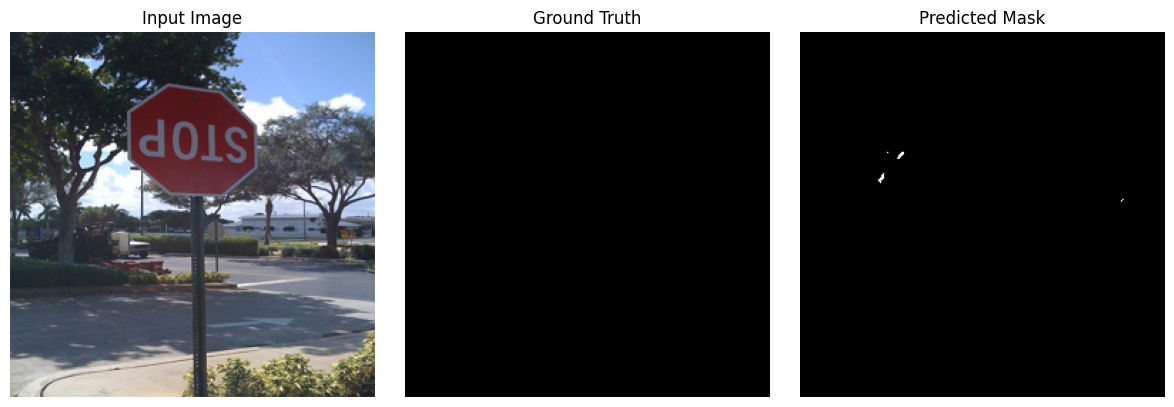

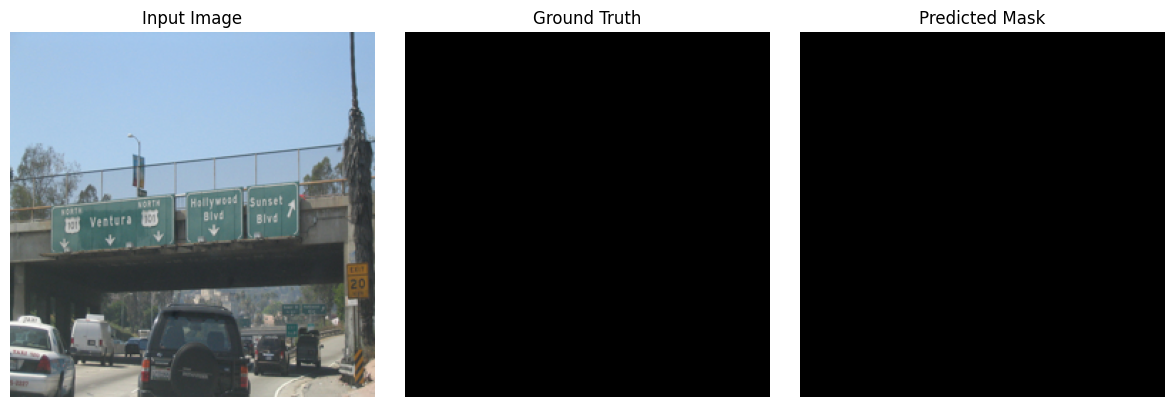

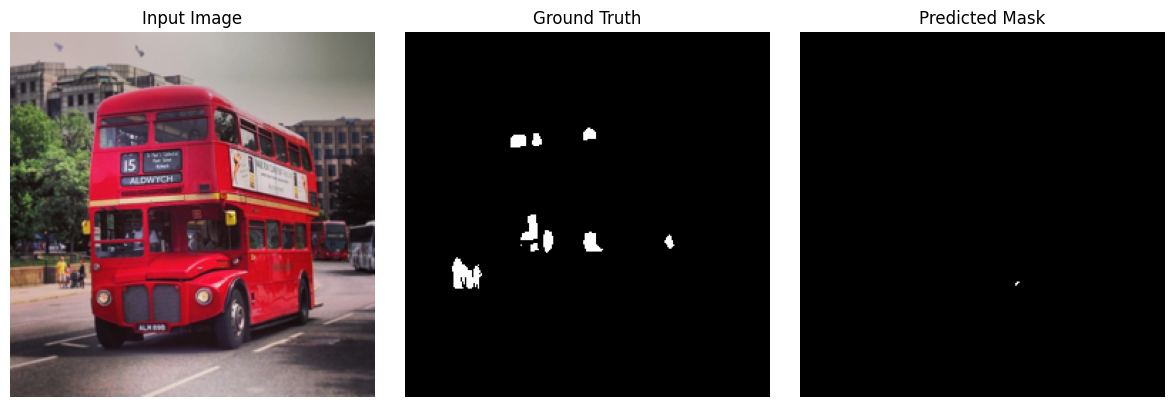

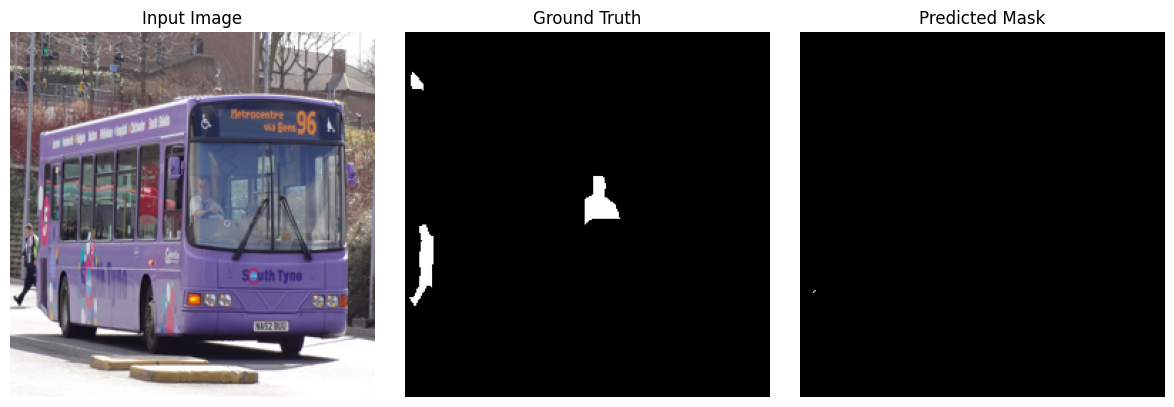

In [ ]:
#Visualizing  Predictions

import matplotlib.pyplot as plt

unet.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = unet(images)
    preds = torch.argmax(outputs, dim=1).cpu()

images = images.cpu()
masks = masks.cpu()

for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images[i].permute(1, 2, 0))
    axs[0].set_title("Input Image")
    axs[1].imshow(masks[i], cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(preds[i], cmap='gray')
    axs[2].set_title("Predicted Mask")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
#Saving the U-NET Model

torch.save(unet.state_dict(), "unet_segmentation_model.pth")
unet.load_state_dict(torch.load("unet_segmentation_model.pth"))
unet.eval()


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [ ]:
# loading the saved model
unet.load_state_dict(torch.load("unet_segmentation_model.pth"))
unet.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [ ]:
# Overall Accuracy with Mean IoU (Intersection over Union)  U-Net

print(f"Overall Pixel Accuracy of U-Net: {metrics['accuracy']:.4f}")
print(f"Mean IoU Score of U-Net : {metrics['mean_iou']:.4f}")

Overall Pixel Accuracy of U-Net: 0.9144
Mean IoU Score of U-Net : 0.2300


In [ ]:
# Per-Class IoU metrics of U-Net

print("Per-Class IoU of u-net:")
print(f"  Background: {metrics['class_ious'][0]:.4f}")

# Iterate through the class_ious starting from the second element
for i in range(1, len(metrics['class_ious']))
    class_id_in_names = list(class_names.keys())[i - 1]
    class_name = class_names[class_id_in_names]
    iou = metrics['class_ious'][i]
    print(f"  {class_name}: {iou:.4f}")

Per-Class IoU of u-net:
  Background: 0.9144
  cake: 0.0000
  car: 0.0000
  dog: 0.0058


# Deeplab Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
# Number of classes = 4 + 1 (background)
num_classes = 5

deeplab_model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model = deeplab_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deeplab_model.parameters(),lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [ ]:
# Training the Deeplab Model
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_loss_history = []
    val_loss_history = []
    val_iou_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs['out'], masks.squeeze(1).long())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)['out']
                loss = criterion(outputs, masks.squeeze(1).long())
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy().flatten())
                all_targets.extend(masks.squeeze(1).cpu().numpy().flatten())

        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        intersection = np.logical_and(np.array(all_preds), np.array(all_targets))
        union = np.logical_or(np.array(all_preds), np.array(all_targets))
        iou = np.sum(intersection) / (np.sum(union) + 1e-6)
        val_iou_history.append(iou)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | IoU: {iou:.4f}")
    correct_pixels = (np.array(all_preds) == np.array(all_targets)).sum()
    total_pixels = len(all_preds)
    overall_accuracy = correct_pixels / total_pixels

    from sklearn.metrics import jaccard_score
    mean_iou_overall = np.mean(jaccard_score(np.array(all_targets), np.array(all_preds), average=None))
    return train_loss_history, val_loss_history, val_iou_history, overall_accuracy, mean_iou_overall # Return val_iou_history

In [ ]:
# Assigning the five returned values to five variables calling funtions to train the model
deeplab_train_loss, deeplab_val_loss, deeplab_val_iou, deeplab_overall_accuracy, deeplab_mean_iou_overall = train_model(
    deeplab_model, train_loader, val_loader, criterion, optimizer, device, epochs=5
)

Epoch 1/5: 100%|██████████| 75/75 [00:32<00:00,  2.32it/s]


Epoch 1/5 - Train Loss: 0.4704 | Val Loss: 0.3367 | IoU: 0.0713


Epoch 2/5: 100%|██████████| 75/75 [00:32<00:00,  2.33it/s]


Epoch 2/5 - Train Loss: 0.4426 | Val Loss: 0.3207 | IoU: 0.0253


Epoch 3/5: 100%|██████████| 75/75 [00:32<00:00,  2.34it/s]


Epoch 3/5 - Train Loss: 0.4189 | Val Loss: 0.3131 | IoU: 0.0743


Epoch 4/5: 100%|██████████| 75/75 [00:31<00:00,  2.38it/s]


Epoch 4/5 - Train Loss: 0.4157 | Val Loss: 0.4248 | IoU: 0.0456


Epoch 5/5: 100%|██████████| 75/75 [00:31<00:00,  2.35it/s]


Epoch 5/5 - Train Loss: 0.4112 | Val Loss: 0.3012 | IoU: 0.1544


# Training and Validation & IoU Loss Deepvlab3

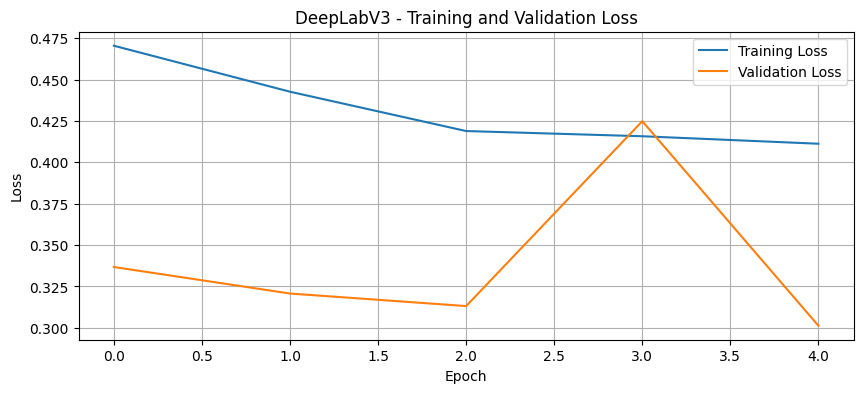

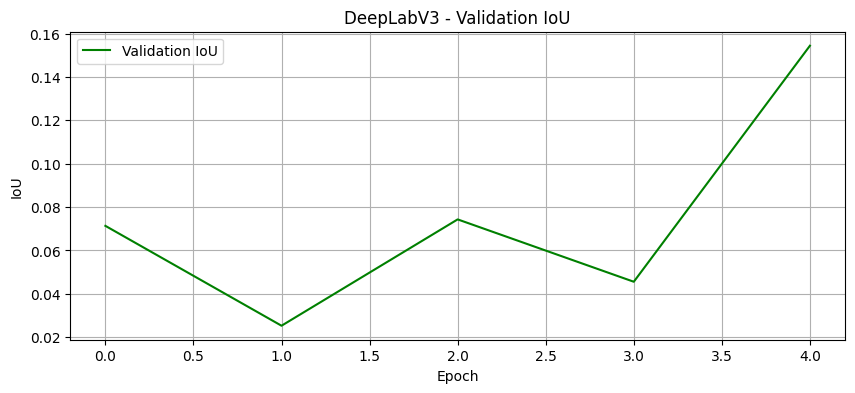

In [ ]:
# Training and Validation Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(deeplab_train_loss, label='Training Loss')
plt.plot(deeplab_val_loss, label='Validation Loss')
plt.title("DeepLabV3 - Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Validation IoU Plot
plt.figure(figsize=(10, 4))
plt.plot(deeplab_val_iou, label='Validation IoU', color='green')
plt.title("DeepLabV3 - Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Saving and loading the deeplab model

torch.save(deeplab_model.state_dict(), "deeplabv3_model.pth")

deeplab_model.load_state_dict(torch.load("deeplabv3_model.pth"))
deeplab_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# Overall metrics of Deeplab
print(f"Overall Pixel Accuracy of deeplab: {deeplab_overall_accuracy:.4f}")
print(f"Mean IoU Score of deeplab: {deeplab_mean_iou_overall:.4f}")

Overall Pixel Accuracy of deeplab: 0.9111
Mean IoU Score of deeplab: 0.2661


# Model Predictions (DeepLabV3)

In [ ]:
 # Deeplab  Predictions  Results

 def visualize_deeplab_predictions(model, dataset, device, class_names, num_samples=4):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            pred = model(image_input)['out']
            pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

            axes[i, 0].imshow(image.permute(1, 2, 0).numpy())
            axes[i, 0].set_title("Original")
            axes[i, 1].imshow(mask.numpy(), cmap='tab10', vmin=0, vmax=len(class_names))
            axes[i, 1].set_title("Ground Truth")
            axes[i, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=len(class_names))
            axes[i, 2].set_title("Predicted")

    plt.tight_layout()
    plt.show()

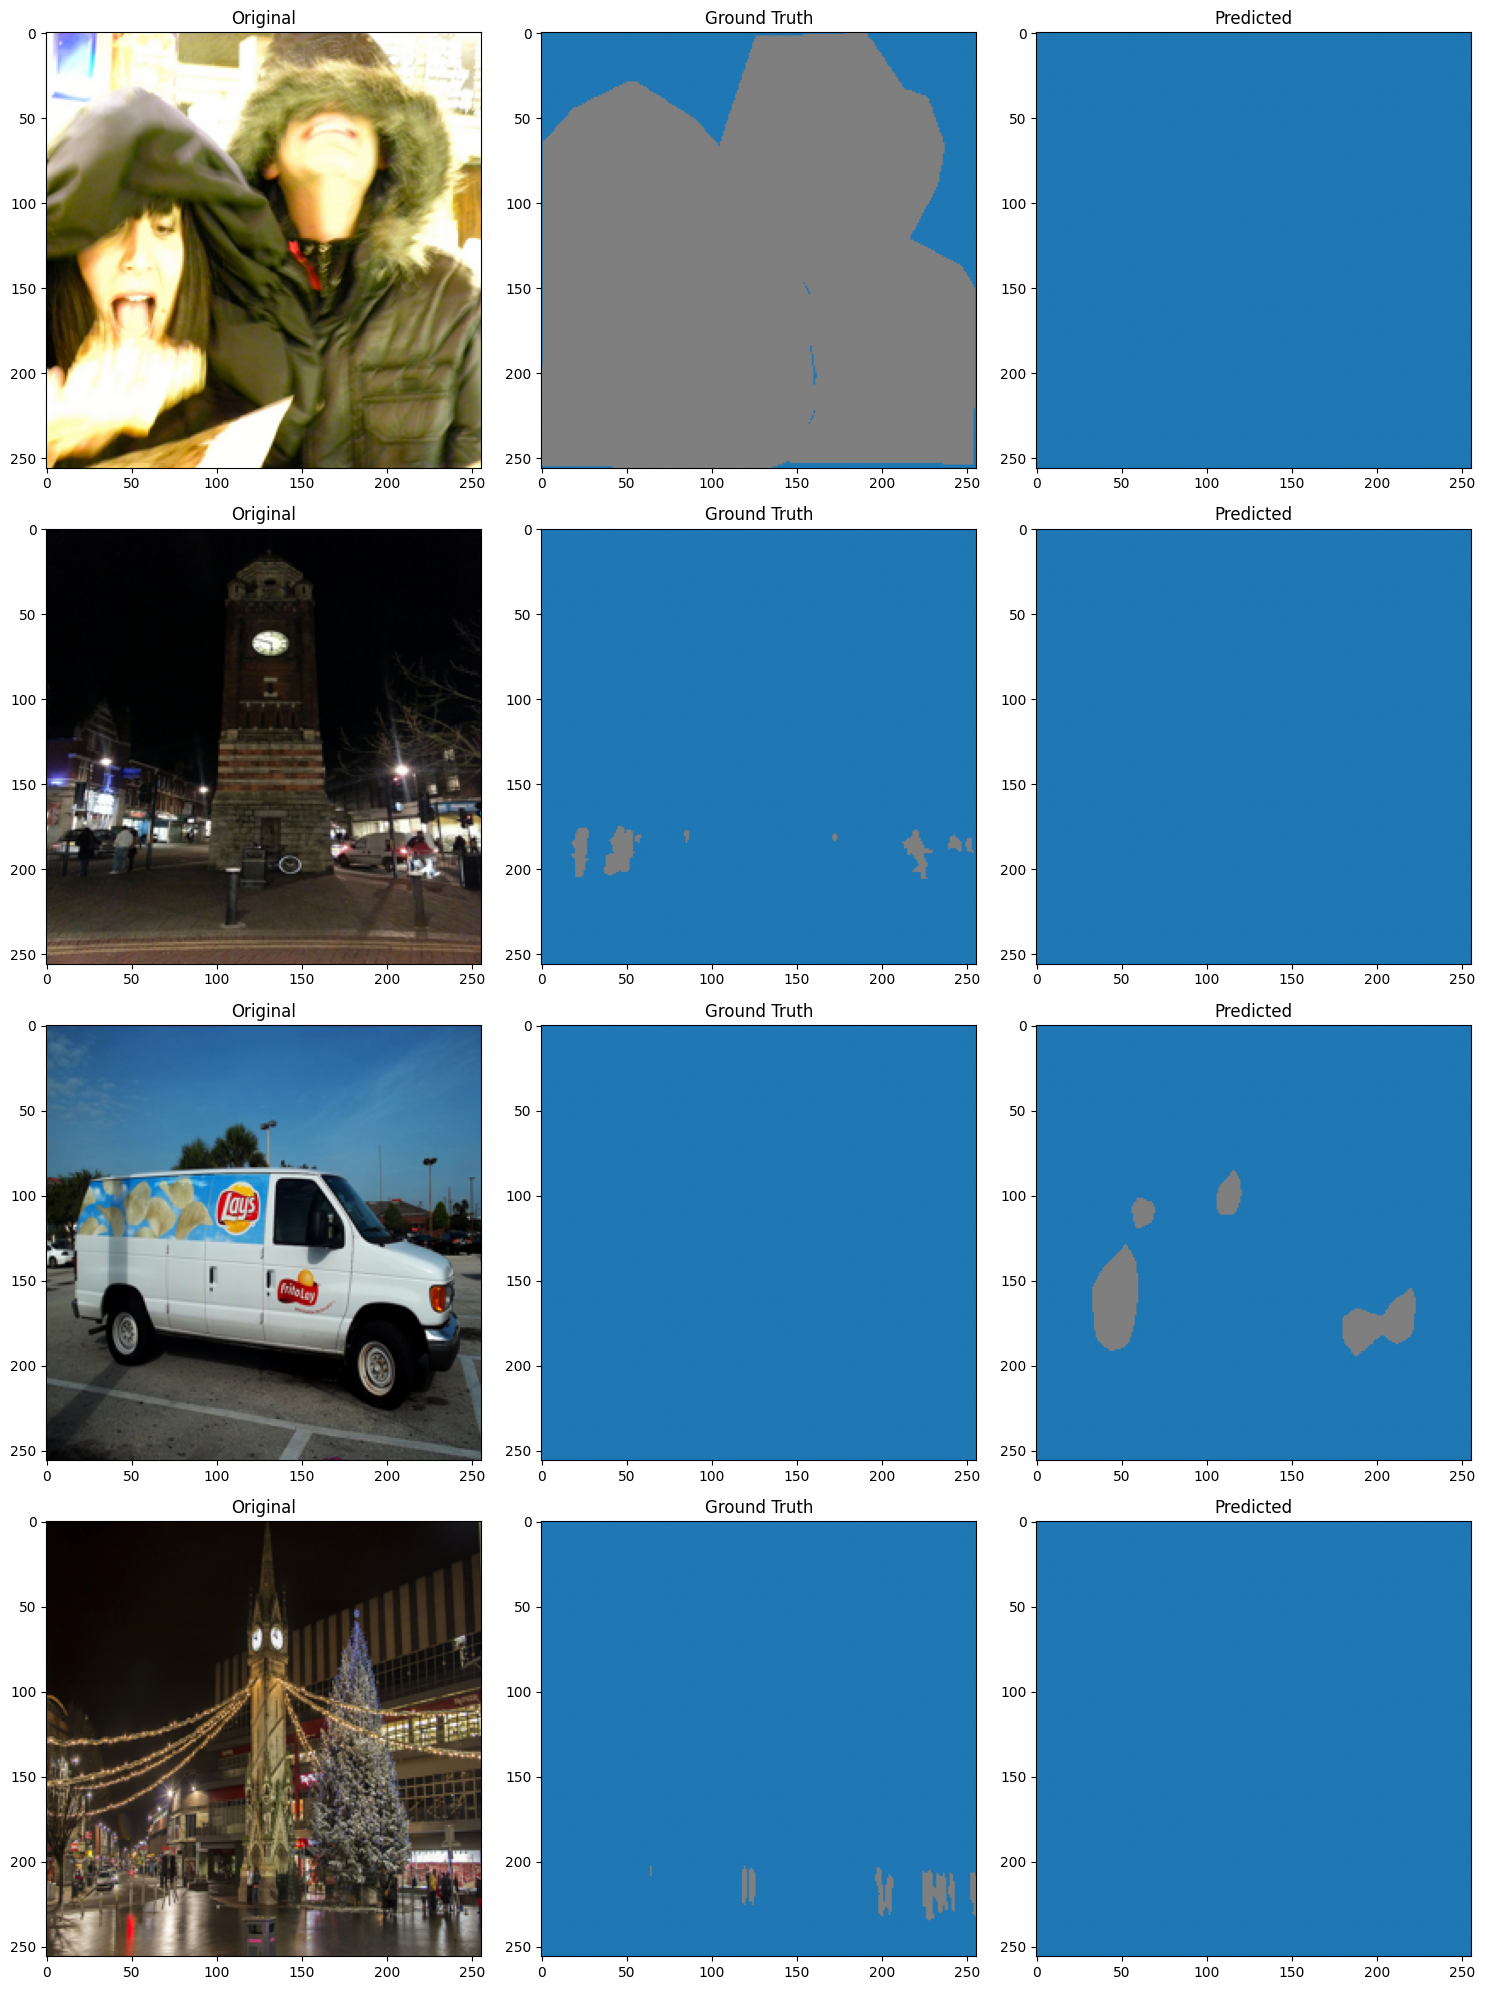

In [ ]:
# visual samples to show
num_samples = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model.to(device)

# Calling the visualization function for prediction results
visualize_deeplab_predictions(
    model=deeplab_model,
    dataset=val_dataset,
    device=device,
    class_names=class_names,
    num_samples=num_samples
)

# Comparison of U-NET and Deeplab models

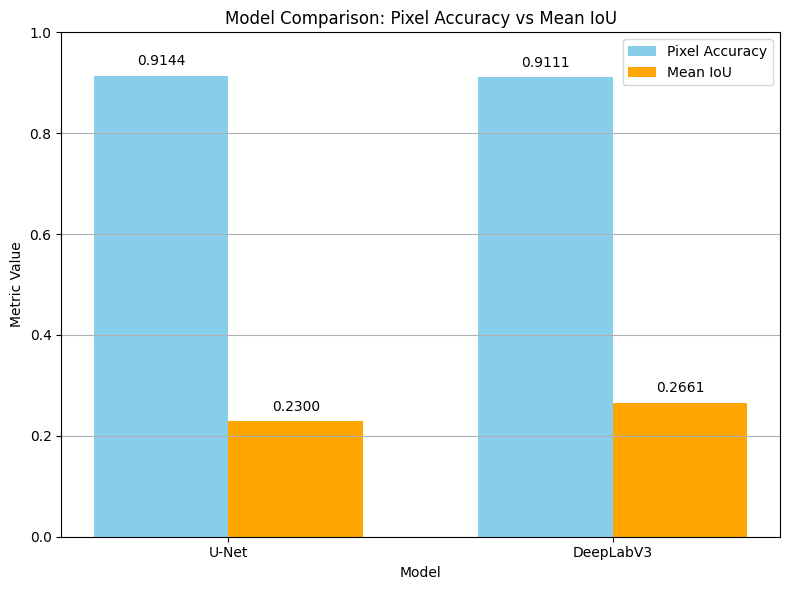

In [ ]:
# results to compare both U-NET and Deeplab model values

import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['U-Net', 'DeepLabV3']
pixel_accuracies = [0.9144, 0.9111]
mean_ious = [0.2300, 0.2661]

# Bar position settings
x = np.arange(len(models))
width = 0.35

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, pixel_accuracies, width, label='Pixel Accuracy', color='skyblue')
plt.bar(x + width/2, mean_ious, width, label='Mean IoU', color='orange')

# Labels and Titles
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Model Comparison: Pixel Accuracy vs Mean IoU')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y')

# Annotate values on bars
for i in range(len(models)):
    plt.text(x[i] - width/2, pixel_accuracies[i] + 0.02, f'{pixel_accuracies[i]:.4f}', ha='center')
    plt.text(x[i] + width/2, mean_ious[i] + 0.02, f'{mean_ious[i]:.4f}', ha='center')

plt.tight_layout()
plt.savefig("model_accuracy_iou_comparison.png")
plt.show()
